In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import matplotlib.patches as mpatches
import matplotlib.colors

from tqdm.notebook import tqdm
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))


from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.diagnostics import plot_sbc
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError

from abf_functions import *

from rnpe_tasks import CS, dists_between, remove_nans_and_warn
from jax import random
from jax import numpy as jnp

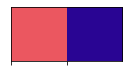

In [30]:
# HYPERSETUP

D = 4 # 4 parameters

random_key_prior = random.PRNGKey(0)
random_key_simulator = random.PRNGKey(1)


plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}',
    'mathtext.fontset' : 'dejavuserif'
})

FILEFORMAT = 'pdf'
DPI = 300

colors = build_viridis_palette(20, base_palette="plasma")
color_codes = {
    "MMS" : "#eb5760",
    "No MMS" : colors[0]
}
sns.palplot(color_codes.values())

arrow_kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=10, head_length=10")

In [124]:
color_codes

{'MMS': '#eb5760', 'No MMS': (0.16407, 0.020171, 0.577478)}

In [3]:
# Setup the CS task from Ward (2022)
cs_task = CS()

In [4]:
class SummaryNet(tf.keras.Model):
    def __init__(self, n_out=4, activation_out=None):
        super(SummaryNet, self).__init__()
        self.intermediate_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="elu"),
            tf.keras.layers.Dense(64, activation="elu"),
            tf.keras.layers.Dense(64, activation="elu")
        ])
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out = self.intermediate_layers(x)
        out = self.out_layer(out)
        return out

In [5]:
# CS model wrapper into BayesFlow API
class Standardizer:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def __call__(self, x):
        out = np.subtract(x, self.mu)
        out = np.divide(out, self.sigma)
        return out

#def standardize(a, mu, sigma):
#    a_shifted = np.subtract(a, np.mean(a, 0))
#    a_standardized = np.divide(a_shifted, np.std(a, 0))
#    return a_standardized

class CSPrior:
    def __init__(self, cs_task, key):
        self.cs_task = cs_task
        self.key = key
        
    def __call__(self, n_sim):
        _, self.key = random.split(self.key)
        theta = self.cs_task.sample_prior(key=self.key, n = n_sim)
        return theta

class CSSimulator:
    def __init__(self, cs_task, key, scale=True, misspecified=False, pi_necrosis = 0.75):
        self.cs_task = cs_task
        self.key = key
        self.scale = scale
        self.misspecified = misspecified
        self.pi_necrosis = pi_necrosis
        
    def __call__(self, theta, n_obs=1):
        _, self.key = random.split(self.key)
        #print(theta.shape)
        #theta = jnp.expand_dims(theta, 0)
        x = self.cs_task.simulate(self.key, theta, necrosis=self.misspecified, summarise=True, pi_necrosis = self.pi_necrosis)
        x = remove_nans_and_warn(x)
        #x = standardize(x)
        return x# jnp.expand_dims(x, 1)


In [6]:
prior = CSPrior(cs_task, random_key_prior)
simulator = CSSimulator(cs_task, random_key_simulator, misspecified=False)
generative_model = GenerativeModel(prior, simulator, skip_consistency_check=True)

In [7]:
theta_train, x_train = generative_model(50000, 1)

In [8]:
standardizer = Standardizer(mu = np.mean(x_train, 0), sigma = np.std(x_train, 0))

In [9]:
summary_net = SummaryNet(n_out=4)

inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 3,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

starter_learning_rate = 0.00001
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=500,
    decay_rate=0.99,
    staircase=True
)


trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=learning_rate,
                      checkpoint_path=f'export_ckpt/mmd/cs_model',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/cs_model/ckpt-20


In [10]:
# losses = trainer.train_offline(epochs=20, batch_size=32, params=theta_train, sim_data=standardizer(x_train))

In [11]:
n_sbc = 2500
n_post_samples_sbc = 100
theta_sbc = prior(n_sbc)
x_sbc = simulator(theta_sbc, 1)
x_sbc = standardizer(x_sbc)
param_samples = np.concatenate([trainer.network.sample(x, n_post_samples_sbc) 
                                for x in tf.split(x_sbc, 10, axis=0)], axis=0)

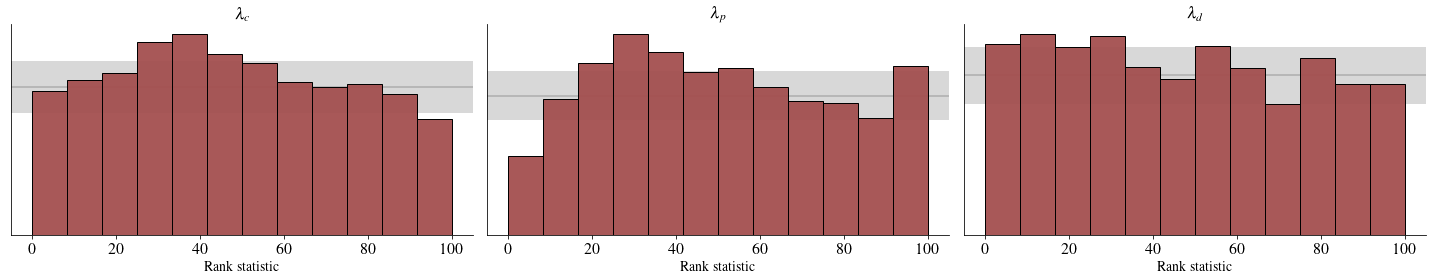

In [12]:
_ = plot_sbc(param_samples, theta_sbc, param_names=[r'$\lambda_c$', r'$\lambda_p$', r'$\lambda_d$'])

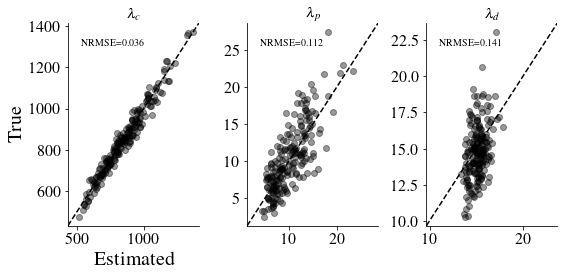

In [13]:
theta, x = generative_model(200, 1)
x = standardizer(x)
param_samples = trainer.network.sample(x, n_samples = 1000)
param_means = np.mean(param_samples, axis=1)

true_vs_estimated(theta, param_means, [r'$\lambda_c$', r'$\lambda_p$', r'$\lambda_d$'], figsize=(8,4), dpi=300,
                          filename="plots/abf_cs_performance.pdf")

In [88]:
prior_misspecified = CSPrior(cs_task, random_key_prior)
simulator_misspecified = CSSimulator(cs_task, random_key_simulator, misspecified=True, pi_necrosis = 0.75)
generative_model_misspecified = GenerativeModel(prior_misspecified, simulator_misspecified, skip_consistency_check=True)

In [89]:
n_sim = 1000

# No MMS
_, x_no_MMS = generative_model(n_sim, 1)
x_no_MMS = standardizer(x_no_MMS)

_, x_MMS = generative_model_misspecified(n_sim, 1)
x_MMS = standardizer(x_MMS)

z_no_MMS = np.array(trainer.network.summary_net(x_no_MMS))
z_MMS = np.array(trainer.network.summary_net(x_MMS))

In [90]:
TASK_NAMES = ['No MMS', 'MMS']
z_ALL = [z_no_MMS, z_MMS]
DF = (pd.DataFrame(z, columns=[r'$z_{%i}$'%i for i in range(1, 5)]) for z in z_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index().drop(columns="level_1")

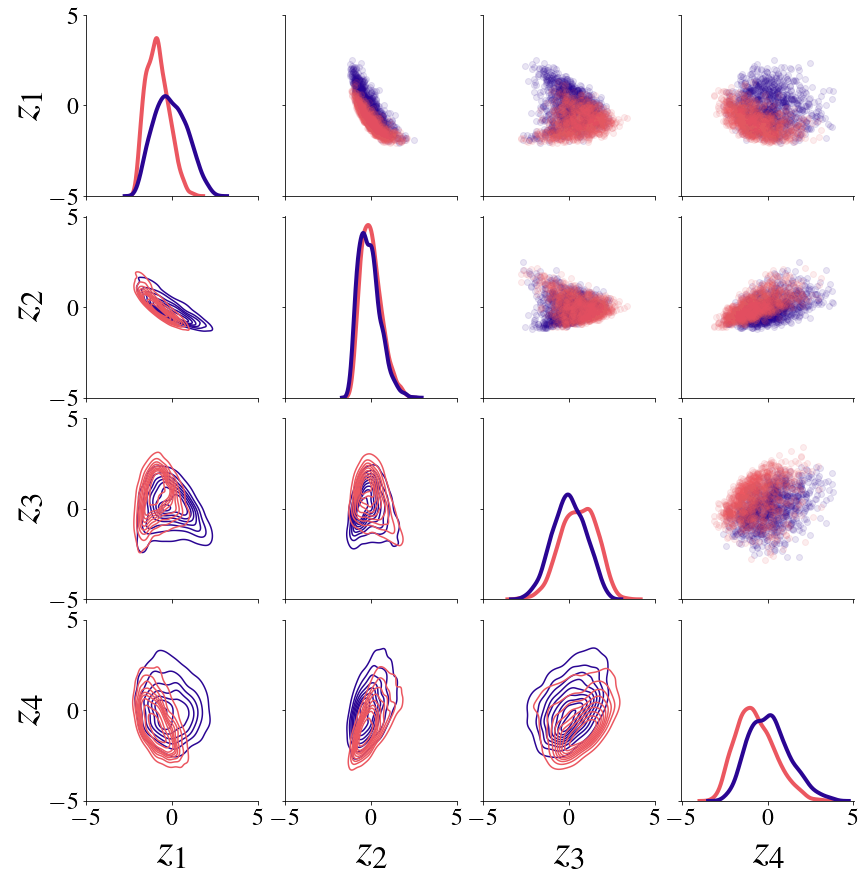

In [123]:
g = sns.PairGrid(df, hue="MMS", height=3, palette=[color_codes[task_name] for task_name in TASK_NAMES])

g.map_diag(sns.kdeplot, linewidth=4)

g.map_lower(sns.kdeplot)

g.map_upper(plt.scatter, alpha=0.1)

handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"Training model $\mathcal{M}$"),
           mpatches.Patch(facecolor=color_codes["MMS"], label=r"Observed process $\mathcal{M}^*$")
           ]

#plt.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(-1.4, -1.3), title="", fontsize=20)

absmax = 5.01 #np.ceil(np.abs(df.iloc[:, 1:].values).max())
ticks = np.arange(-100, 100, 5)
ticks = ticks[(ticks>-absmax) & (ticks<absmax)]


for ax in g.axes.flatten():
    ax.set_xlim(-absmax, absmax)
    ax.set_ylim(-absmax, absmax)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.xaxis.label.set_fontsize(42)
    ax.yaxis.label.set_fontsize(42)
plt.savefig(f"plots/cs_pairplot.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

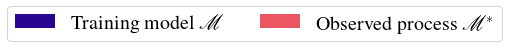

In [94]:
plt.figure(figsize=(0.1,0.1))
plt.gca().set_axis_off()
handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"Training model $\mathcal{M}$"),
           mpatches.Patch(facecolor=color_codes["MMS"], label=r"Observed process $\mathcal{M}^*$")
           ]
plt.legend(handles=handles, loc="center", ncol=4, title="" ,fontsize=20, labelspacing=2)
plt.savefig(f"plots/cm_pairplot_legend.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

## MMD as a function of Misspecification

In [86]:
key_simulator = random_key_simulator
key_prior = random_key_prior
n_sim = 100
n_runs_per_pi = 20


n_pi = 61
pi_list = np.linspace(0.0, 1.0, num = n_pi)

MMD = np.zeros((n_pi, n_runs_per_pi))
for i, pi in tqdm(enumerate(pi_list)):
    for j in range(n_runs_per_pi):
        _, key_simulator = random.split(key_simulator)
        _, key_prior = random.split(key_prior)
        
        _, x = trainer._forward_inference(n_sim, 1)
        x = standardizer(x)
        z = np.array(trainer.network.summary_net(x))
        
        prior = CSPrior(cs_task, key_prior)
        simulator_misspecified = CSSimulator(cs_task, key = key_simulator, misspecified=True, pi_necrosis=pi)
        generative_model_misspecified = GenerativeModel(prior, simulator_misspecified, skip_consistency_check=True)
        _, x_o = generative_model_misspecified(n_sim, 1)
        x_o = standardizer(x_o)

        z_o = np.array(trainer.network.summary_net(x_o))
        MMD[i, j] = float(maximum_mean_discrepancy(z_o, z, squared=False))

0it [00:00, ?it/s]

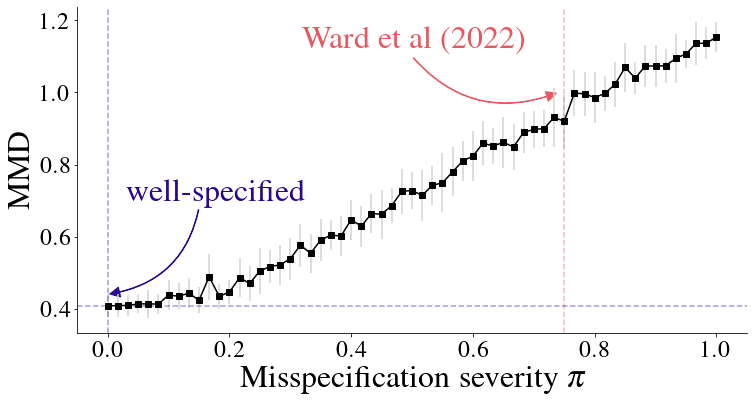

In [110]:
f, ax = plt.subplots(figsize=(12, 6))
ax.axvline(x=0.75, color=color_codes["MMS"], ls="--",alpha=.40)
ax.axhline(y = np.mean(MMD[0]), color=color_codes['No MMS'], ls="--", alpha=.40)
ax.axvline(x=0.0, color=color_codes['No MMS'], ls="--",alpha=.40)
ax.errorbar(pi_list, np.mean(MMD, axis=1), yerr=np.std(MMD, axis=1), marker='s', ecolor='lightgray', color="black")


ax.set_xlabel(r'Misspecification severity $\pi$', fontsize=32)
ax.set_ylabel("MMD", fontsize=32)

ax.text(0.32, 1.12, r"Ward et al (2022)", fontsize=32, color = color_codes['MMS']) 
ax.add_patch(mpatches.FancyArrowPatch((0.5, 1.1), (0.74, 1.0), connectionstyle="arc3,rad=.35", color=color_codes['MMS'], **arrow_kw))

ax.text(0.03, 0.7, r"well-specified", fontsize=32, color = color_codes['No MMS']) 
ax.add_patch(mpatches.FancyArrowPatch((0.15, 0.68), (0, 0.44), connectionstyle="arc3,rad=-.35", color=color_codes['No MMS'], **arrow_kw))


ax.tick_params(axis='both', which='major', labelsize=24)
sns.despine()

plt.savefig("plots/cs_mms_mmd.pdf", dpi=300, bbox_inches="tight")

In [ ]:
def MMD_bootstrap(x, x_o, N_BOOTSTRAP_ITERATIONS=10, n_samples_x=1000, n_samples_x_o=1000):
    n_x = x.shape[0]
    n_x_o = x_o.shape[0]
    
    MMD_bootstrap = np.empty(N_BOOTSTRAP_ITERATIONS)

    for i in tqdm(range(N_BOOTSTRAP_ITERATIONS)):
        idx_x = np.random.randint(0, n_x, size=n_samples_x)
        idx_x_o = np.random.randint(0, n_x_o, size=n_samples_x_o)
        
        x_bootstrap = x[idx_x]
        x_o_bootstrap = x_o[idx_x_o]
        
        z_bootstrap = np.array(trainer.network.summary_net(x_bootstrap))
        z_o_bootstrap = np.array(trainer.network.summary_net(z_o_bootstrap))
        
        MMD_bootstrap[i] = float(maximum_mean_discrepancy(z_bootstrap, z_o_bootstrap, squared=False))
        
    return MMD_bootstrap

def calculate_CI(x, ci_area=0.95):
    q_lower = round((1.0 - ci_area) / 2, 5)
    q_upper = round(1.0 - q_lower, 5)
    return np.quantile(x, q_lower), np.quantile(x, q_upper)

In [ ]:
n_sim = 1000

_, x = trainer._forward_inference(n_sim, 1)
x = standardizer(x)

_, x_o = generative_model_misspecified(n_sim, 1)
x_o = standardizer(x_o)

MMD_bootstrap = MMD_bootstrap(x, x_o, N_BOOTSTRAP_ITERATIONS = 100, n_samples_x = 1000, n_samples_x_o = 1000)

In [ ]:
lower_bound, upper_bound = calculate_CI(MMD_bootstrap, ci_area=0.95)
median = np.median(MMD_bootstrap)
print(f"N = {n_samples_test}:   M{i}: {median:.2f} [{lower_bound:.2f}, {upper_bound:.2f}]")

## Power

In [96]:
def fill_area_under_kde(kde_object, x_start, x_end=None, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    if x_end is not None:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start) & (kde_x<=x_end), 
                    interpolate=True, **kwargs)
    else:
        plt.fill_between(kde_x, kde_y, where=(kde_x>=x_start), 
                    interpolate=True, **kwargs)


In [97]:
n_H0_simulations = 100
n_H1_simulations = 100

n_sim_x = 100
n_sim_x_o = 100

alpha = 0.05


prior_misspecified = CSPrior(cs_task, random_key_prior)
simulator_misspecified = CSSimulator(cs_task, random_key_simulator, misspecified=True, pi_necrosis = 0.75)
generative_model_misspecified = GenerativeModel(prior_misspecified, simulator_misspecified, skip_consistency_check=True)


MMD_H0 = np.empty(n_H0_simulations)
MMD_H1 = np.empty(n_H1_simulations)

for i in tqdm(range(n_H0_simulations), desc="Compute MMD under H0 and H1"):
    ## H0
    _, x = trainer._forward_inference(n_sim_x, 1)
    x = standardizer(x)
    z = trainer.network.summary_net(x)
    
    _, x_prime = trainer._forward_inference(n_sim_x_o, 1)
    x_prime = standardizer(x_prime)
    z_prime = trainer.network.summary_net(x_prime)
    
    MMD_H0[i] = float(maximum_mean_discrepancy(z, z_prime, squared=False))
    
    
    ## H1                
    _, x = trainer._forward_inference(n_sim_x, 1)
    x = standardizer(x)
    z = trainer.network.summary_net(x)
    
    _, x_mms = generative_model_misspecified(n_sim_x_o, 1)
    x_mms = standardizer(x_mms)
    z_mms = trainer.network.summary_net(x_mms)
    
    MMD_H1[i] = float(maximum_mean_discrepancy(z, z_mms, squared=False))
MMD_critical = np.quantile(MMD_H0, 1-alpha)    
power = (MMD_H1 > MMD_critical).mean()    

Compute MMD under H0 and H1:   0%|          | 0/100 [00:00<?, ?it/s]

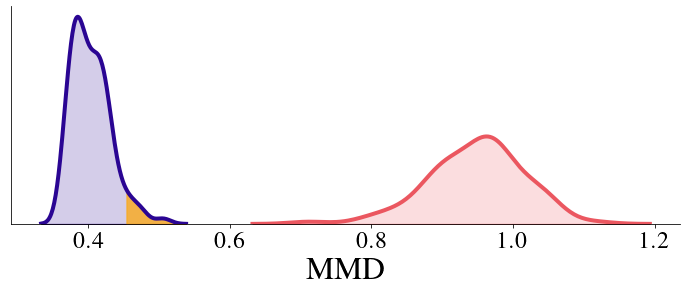

In [116]:
H0_color = color_codes["No MMS"]#"#287D8EFF"
model_color = color_codes["MMS"]
alpha_color = "orange"

fig, ax = plt.subplots(figsize=(12, 4))

kde_H0 = sns.kdeplot(MMD_H0, linewidth=4, label=r"$H_0$", color=H0_color)
sns.kdeplot(MMD_H0, fill=True, alpha=.2, color = H0_color)

kde_test = sns.kdeplot(MMD_H1, ax=ax, linewidth=4, label=r"$\mathcal{M}^*$", color=model_color)
sns.kdeplot(MMD_H1, fill=True, alpha=.2, color = model_color)

fill_area_under_kde(kde_H0, MMD_critical, color=alpha_color, alpha=0.7, label=r"5\% rejection area")

ax.set_xlabel("MMD", fontsize=32)
ax.set_ylabel("")
ax.set_yticks([])
ax.set_xlim(None, None)

ax.tick_params(axis='both', which='major', labelsize=24)

#ax.legend(fontsize=16)
sns.despine()

handles = [mpatches.Patch(facecolor=H0_color, 
                          #label=r"$\hat{p}(\widehat{\mathrm{rMMD}}\,|\,H_0)$")
                          label = r"$\widehat{\mathrm{rMMD}}$ under $H_0$"),
           mpatches.Patch(facecolor=model_color,
                          #label=r"$\hat{p}(\widehat{\mathrm{rMMD}}\,|\,{\fontfamily{cm}\selectfont\mathcal{M}}_j)$")
                          label = r"$\widehat{\mathrm{rMMD}}$ under $M^*$"),
           mpatches.Patch(facecolor=alpha_color, label=r"$H_0$ rejection area")]

#plt.legend(handles=handles, ncol=1, title="" ,fontsize=20, labelspacing=1, 
           #loc="center right", bbox_to_anchor=(1.5, 0.5))

plt.savefig("plots/cs_mms_power.pdf", dpi=300, bbox_inches="tight")

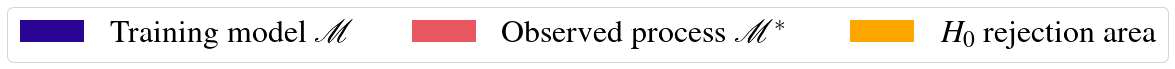

In [112]:
plt.figure(figsize=(0.1,0.1))
plt.gca().set_axis_off()
handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"Training model $\mathcal{M}$"),
           mpatches.Patch(facecolor=color_codes["MMS"], label=r"Observed process $\mathcal{M}^*$"),
           mpatches.Patch(facecolor="orange", label=r"$H_0$ rejection area"),
           ]
plt.legend(handles=handles, loc="center", ncol=3, title="" ,fontsize=32, labelspacing=2)
plt.savefig(f"plots/cs_legend.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)